Imports

In [1]:
#Omid55
import math
import collections
import sklearn as sk
import numpy as np
import seaborn as sns
from numpy import linalg as LA
import matplotlib.pyplot as plt
from scipy.stats import norm
import random as rand
from sklearn import cross_validation
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
import pandas as pd
from sklearn.neighbors import KNeighborsClassifier
%matplotlib inline
#from sklearn.neural_network import MLPClassifier

Loading the data

In [162]:
matches = np.genfromtxt('matches_reduced.csv', delimiter=',', skip_header=True)
TEAM_SIZE = 5
members = np.genfromtxt('members_in_matches_reduced.csv', delimiter=',', skip_header=True)

In [213]:
def clean_it(dataset):
    TEAM_SIZE = 5
    # remove those teams with 3 members
    print dataset.shape
    dataset = np.delete(dataset,np.where(dataset == -1)[0],axis=0) 
    print dataset.shape
    
    # remove identical matches
    dataset = unique_rows(dataset)
    print dataset.shape
    
    # remove identical teams
    if dataset.shape[1] <= 2*TEAM_SIZE + 1:
        # just champion levels
        dataset = np.delete(dataset, np.where(np.sum(dataset[:,:TEAM_SIZE] - dataset[:,TEAM_SIZE:2*TEAM_SIZE],axis=1)==0),axis=0)
    else:
        # champion levels and members
        dataset = np.delete(dataset, np.where(np.sum(dataset[:,:TEAM_SIZE] - dataset[:,TEAM_SIZE:2*TEAM_SIZE] + 
          dataset[:,2*TEAM_SIZE:3*TEAM_SIZE] - dataset[:,3*TEAM_SIZE:-1], axis=1) == 0), axis=0)
    print dataset.shape
    
    return dataset

In [218]:
matches = clean_it(matches)

(102684, 10)
(100618, 10)
(32707, 10)
(31978, 10)


In [151]:
def unique_rows(A, return_index=False, return_inverse=False):
    """
    Similar to MATLAB's unique(A, 'rows'), this returns B, I, J
    where B is the unique rows of A and I and J satisfy
    A = B[J,:] and B = A[I,:]

    Returns I if return_index is True
    Returns J if return_inverse is True
    """
    A = np.require(A, requirements='C')
    assert A.ndim == 2, "array must be 2-dim'l"

    B = np.unique(A.view([('', A.dtype)]*A.shape[1]),
               return_index=return_index,
               return_inverse=return_inverse)

    if return_index or return_inverse:
        return (B[0].view(A.dtype).reshape((-1, A.shape[1]), order='C'),) \
            + B[1:]
    else:
        return B.view(A.dtype).reshape((-1, A.shape[1]), order='C')

Analysis

In [3]:
def compute_difference_of_winners_from_losers(matches):
    diff = np.zeros(len(matches))
    for i, match in enumerate(matches):
        loser = match[:TEAM_SIZE]
        winner = match[TEAM_SIZE:]
        diff[i] = LA.norm(winner,2) - LA.norm(loser,2)
        
    sns.set(rc={"figure.figsize": (20, 10)})
    
    ax = sns.distplot(diff)
    ax.set(xlabel='norm2(winner) - norm2(loser)', ylabel='Volume')
    
    sns.distplot(diff, fit=norm, kde=True)
    sns.plt.show()
    
    plt.hist(diff, bins=30)
    plt.xlabel("norm2(winner) - norm2(loser)")
    plt.ylabel("Volume")
    fig = plt.gcf()
    
    print 'positive percentage: ', 100*float(len(np.where(diff > 0)[0]))/len(diff)
    print 'zero percentage: ', 100*float(len(np.where(diff == 0)[0]))/len(diff)
    print 'negative percentage: ', float(100*len(np.where(diff < 0)[0]))/len(diff)
    
    return diff

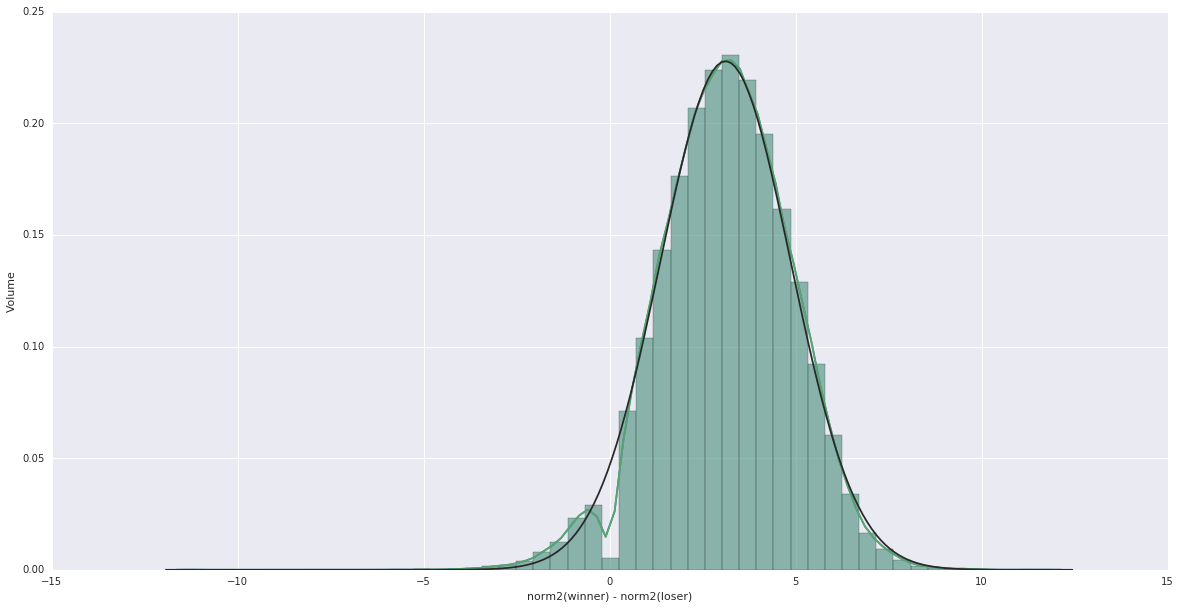

positive percentage:  96.1348427044
zero percentage:  0.0093814497467
negative percentage:  3.85577584589


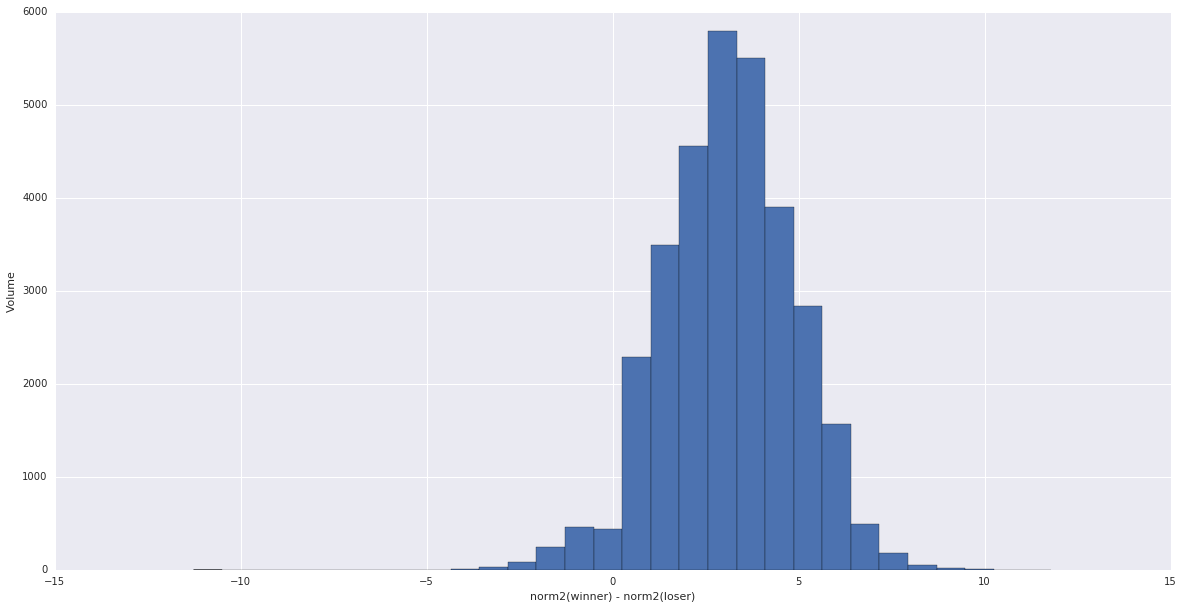

In [219]:
diff = compute_difference_of_winners_from_losers(matches)

Selecting from dataset to make it harder

In [234]:
sorted_diff = np.sort(diff)
c = np.where(sorted_diff == 0)[0]
center_index = c[math.floor(len(c)/2)]
LEN = 1234
beg_diff = sorted_diff[center_index-LEN]
end_diff = sorted_diff[center_index+LEN]

sampled_indices = np.where((diff >= beg_diff) * (end_diff >= diff))[0]
print(len(sampled_indices), 'number of matches is sampled.')
sampled_matches = matches[sampled_indices]
np.savetxt(
    'close_matches.csv',
    sampled_matches,
    fmt='%d',
    delimiter=',',
    newline='\n',  # new line character
    footer='',  # file footer
    comments='',  # character to use for comments
    header='team1_member1,team1_member2,team1_member3,team1_member4,team1_member5,'
        + 'team2_member1,team2_member2,team2_member3,team2_member4,team2_member5'
    )

(2469, 'number of matches is sampled.')


/cs/student/omid55/.local/lib/python2.7/site-packages/ipykernel/__main__.py:3: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  app.launch_new_instance()


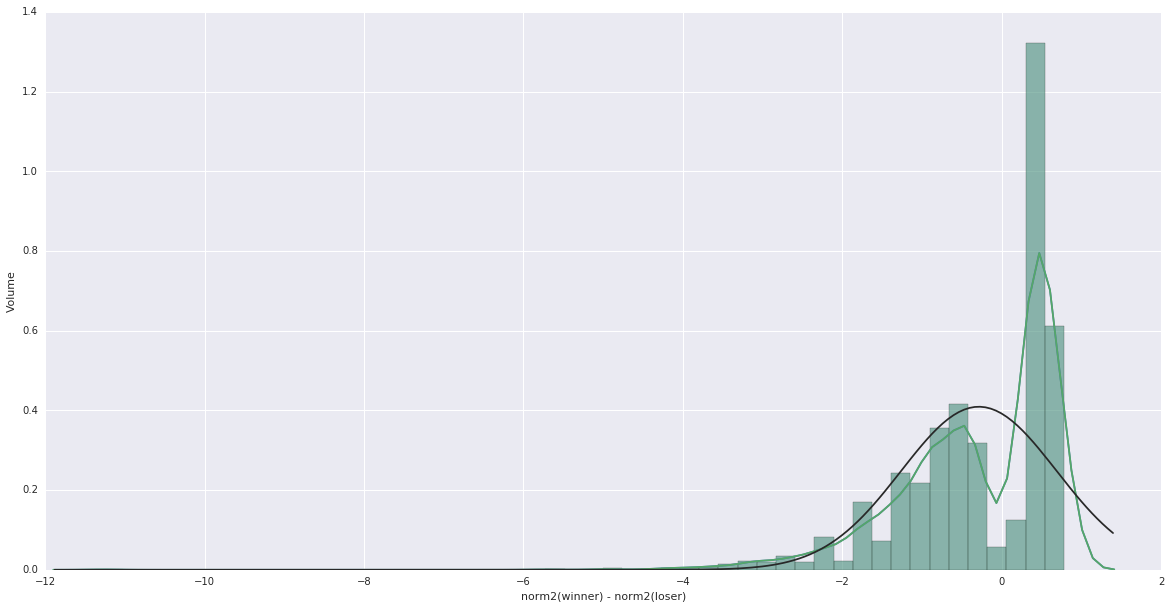

positive percentage:  49.9392466586
zero percentage:  0.121506682868
negative percentage:  49.9392466586


array([ 0.66925583,  0.37474949,  0.54020657, ..., -1.24922359,
       -0.85379239, -0.43716512])

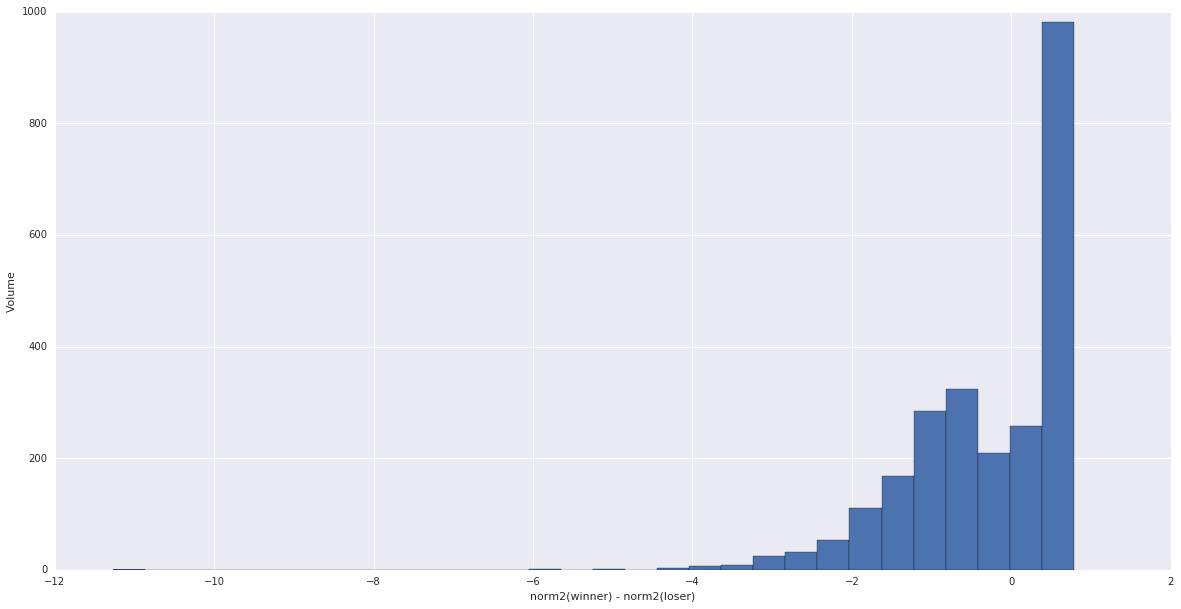

In [226]:
compute_difference_of_winners_from_losers(sampled_matches)

Creating the dataset for classification

In [205]:
def create_dataset_with_members(matches, name):
    members_dict = collections.defaultdict(lambda: 0)
    dataset = np.zeros([matches.shape[0], 2*matches.shape[1]+1])
    dataset[:,:matches.shape[1]] = matches
    
    for i in range(matches.shape[0]):
        for j, member in enumerate(members[i]):
            if member:
                dataset[i, matches.shape[1]+j] = members_dict[member]
                members_dict[member] += 1
    
    dataset[:,-1] = 0
    # clean the dataset
    dataset = clean_it(dataset)
    
    # fliping half of the dataset into 'winner, loser'
    idx = np.random.choice(len(dataset), int(len(dataset)/2), replace=False)
    tmp = dataset[idx,TEAM_SIZE:2*TEAM_SIZE]
    dataset[idx,TEAM_SIZE:2*TEAM_SIZE] = dataset[idx,:TEAM_SIZE]
    dataset[idx,:TEAM_SIZE] = tmp
    tmp = dataset[idx, 2*TEAM_SIZE:3*TEAM_SIZE]
    dataset[idx, 2*TEAM_SIZE:3*TEAM_SIZE] = dataset[idx, 3*TEAM_SIZE:-1]
    dataset[idx, 3*TEAM_SIZE:-1] = tmp
    dataset[idx,-1] = 1
    
    np.savetxt(
        name,
        dataset,
        fmt='%d',
        delimiter=',',
        newline='\n',  # new line character
        footer='',  # file footer
        comments='',  # character to use for comments
        header='team1_member1,team1_member2,team1_member3,team1_member4,team1_member5,'
            + 'team2_member1,team2_member2,team2_member3,team2_member4,team2_member5,'
            + 'team1_member1_plays,team1_member2_plays,team1_member3_plays,team1_member4_plays,team1_member5_plays,'
            + 'team2_member1_plays,team2_member2_plays,team2_member3_plays,team2_member4_plays,team2_member5_plays,'
            + 'label'
        )
    
    return dataset

In [170]:
def create_dataset(matches, name):
    dataset = np.zeros([matches.shape[0], matches.shape[1]+1])
    dataset[:,:-1] = matches
    dataset[:,-1] = 0
    
    # clean the dataset
    dataset = clean_it(dataset)
    
    idx = np.random.choice(len(dataset), int(len(dataset)/2), replace=False)
    tmp = dataset[idx,TEAM_SIZE:-1]
    dataset[idx,TEAM_SIZE:-1] = dataset[idx,:TEAM_SIZE]
    dataset[idx,:TEAM_SIZE] = tmp
    dataset[idx,-1] = 1
    
    np.savetxt(
        name,
        dataset,
        fmt='%d',
        delimiter=',',
        newline='\n',  # new line character
        footer='',  # file footer
        comments='',  # character to use for comments
        header='team1_member1,team1_member2,team1_member3,team1_member4,team1_member5,'
            + 'team2_member1,team2_member2,team2_member3,team2_member4,team2_member5,label'
        )
    
    return dataset

Classification

In [104]:
def do_classification(dataset):
    
    # creating the models
    lr = LogisticRegression()
    rfc = RandomForestClassifier(n_estimators=100)
    gnb = GaussianNB()
    svc = svm.LinearSVC(C=1.0)
    svc_rbf = svm.SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
        decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
        max_iter=-1, probability=False, random_state=None, shrinking=True,
        tol=0.001, verbose=True)
    knn = KNeighborsClassifier(n_neighbors=8)
    #clf = MLPClassifier(algorithm='l-bfgs', alpha=1e-5, hidden_layer_sizes=(5, 2), random_state=1)

    models = [(lr, 'Logistic Regression'),
        (gnb, 'Naive Bayes'),
        (svc, 'Linear SVM'),
        (svc_rbf, 'SVM with RBF kernel'),
        (rfc, 'Random Forest'),
        (knn, 'KNN')]

    # applying the models
    n_folds = 10
    k_fold = cross_validation.KFold(n=len(dataset), n_folds=n_folds, shuffle=False, random_state=None)
    accuracy = {}
    for train_index, test_index in k_fold:
        X_train = dataset[train_index,:-1]
        y_train = dataset[train_index,-1]
        X_test = dataset[test_index,:-1]
        y_test = dataset[test_index,-1]

        for clf, name in models:
            clf.fit(X_train, y_train)
            y_pred = clf.predict(X_test)
            accuracy_percent = 100 * sk.metrics.accuracy_score(y_test, y_pred) / n_folds
            if name not in accuracy:
                accuracy[name] = accuracy_percent
            else:
                accuracy[name] += accuracy_percent

    print '\n'
    for key, value in accuracy.items():
        print key, ':', round(value,2)

Results of classification

In [235]:
dataset = create_dataset(matches, 'dataset.csv')
do_classification(dataset)

(31978, 11)
(31978, 11)
(31978, 11)
(31978, 11)
[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]

KNN : 93.49
SVM with RBF kernel : 93.31
Naive Bayes : 94.95
Linear SVM : 95.24
Logistic Regression : 96.04
Random Forest : 85.76


In [236]:
sampled_dataset = create_dataset(sampled_matches, 'sampled_dataset.csv')
do_classification(sampled_dataset)

(2469, 11)
(2469, 11)
(2469, 11)
(2469, 11)
[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]

KNN : 43.95
SVM with RBF kernel : 46.67
Naive Bayes : 51.4
Linear SVM : 50.22
Logistic Regression : 51.01
Random Forest : 27.14


Classification of the dataset with adding members' experience information

In [237]:
dataset = create_dataset_with_members(matches, 'dataset_with_members.csv')
do_classification(dataset)

(31978, 21)
(31978, 21)
(31978, 21)
(31936, 21)
[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]

KNN : 78.9
SVM with RBF kernel : 81.01
Naive Bayes : 90.93
Linear SVM : 92.37
Logistic Regression : 96.06
Random Forest : 88.95


In [238]:
sampled_dataset = create_dataset_with_members(sampled_matches, 'sampled_dataset_with_members.csv')
do_classification(sampled_dataset)

(2469, 21)
(2469, 21)
(2469, 21)
(2407, 21)
[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]

KNN : 50.32
SVM with RBF kernel : 48.28
Naive Bayes : 48.24
Linear SVM : 52.1
Logistic Regression : 50.09
Random Forest : 30.59
